In [3]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import MinMaxScaler

from datetime import datetime


# Import dataset
data = pd.read_csv('/AirPassengers.csv')
data['Month'] = pd.to_datetime(data['Month'])
data.set_index('Month', inplace=True)

Observations: 144
Training Observations: 115
Testing Observations: 29


/usr/local/lib/python3.7/dist-packages/numpy/core/shape_base.py:65: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ary = asanyarray(ary)


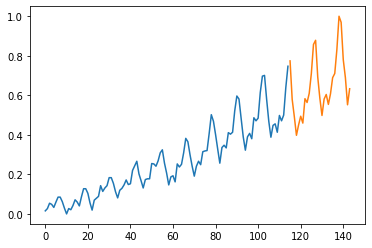

In [4]:
# Scale the data for pre-processing
scaler = MinMaxScaler()
data = scaler.fit_transform(data)

# Split the data
train_size = int(len(data) * 0.8)
train, test = data[0:train_size], data[train_size:len(data)]
print('Observations: %d' % (len(data)))
print('Training Observations: %d' % (len(train)))
print('Testing Observations: %d' % (len(test)))

# Plot the train and test data
plt.plot(train)
plt.plot([None for i in train] + [x for x in test])
plt.show()

# convert an array of values into a dataset matrix
def create_dataset(dataset, look_back=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-look_back-1):
		a = dataset[i:(i+look_back), 0]
		dataX.append(a)
		dataY.append(dataset[i + look_back, 0])
	return np.array(dataX), np.array(dataY)

# reshape into X=t and Y=t+1
look_back = 1
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)

In [5]:
# The LSTM network expects the input data (X) to be provided with a specific 
# array structure in the form of: [samples, time steps, features].
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))


In [7]:
# LSTM Model
model = Sequential()
model.add(LSTM(32, input_shape=(1, look_back)))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.summary()
history = model.fit(trainX, trainY, epochs=100, batch_size=1, verbose=2)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_1 (LSTM)               (None, 32)                4352      
                                                                 
 dense_1 (Dense)             (None, 1)                 33        
                                                                 
Total params: 4,385
Trainable params: 4,385
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
113/113 - 5s - loss: 0.0407 - 5s/epoch - 46ms/step
Epoch 2/100
113/113 - 0s - loss: 0.0178 - 325ms/epoch - 3ms/step
Epoch 3/100
113/113 - 1s - loss: 0.0137 - 917ms/epoch - 8ms/step
Epoch 4/100
113/113 - 0s - loss: 0.0100 - 326ms/epoch - 3ms/step
Epoch 5/100
113/113 - 0s - loss: 0.0071 - 349ms/epoch - 3ms/step
Epoch 6/100
113/113 - 0s - loss: 0.0053 - 318ms/epoch - 3ms/step
Epoch 7/100
113/113 - 0s - loss: 0.0039 - 334ms/epoch - 3ms/

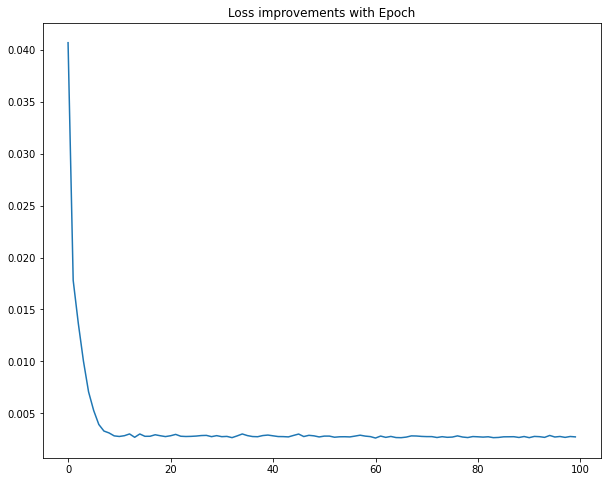

In [10]:
pd.DataFrame(history.history)["loss"].plot(figsize=(10, 8))
plt.title("Loss improvements with Epoch")
plt.show()

In [14]:
import math
# make predictions
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)

In [17]:
# invert predictions
trainPredict = scaler.inverse_transform(trainPredict)
testPredict = scaler.inverse_transform(testPredict)

In [21]:
# calculate root mean squared error
from sklearn.metrics import mean_squared_error
import math
trainScore = math.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))

Train Score: 26.30 RMSE
Test Score: 51.66 RMSE


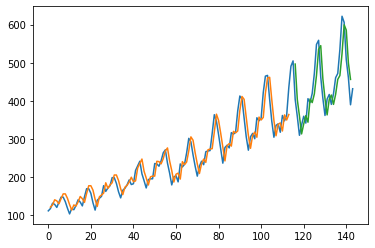

In [31]:

# shift train predictions for plotting
trainPredictPlot = np.empty_like(data)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict
# shift test predictions for plotting
testPredictPlot = np.empty_like(data)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(data)-1, :] = testPredict
# plot baseline and predictions
plt.plot(scaler.inverse_transform(data))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()